In [1]:
import numpy as np
import pandas as pd
import re
import time
import jpype
import tensorflow as tf

In [2]:
df = pd.read_csv('./review_tag&label_prepared.csv', index_col=0,encoding='utf-8')
df.shape

(330938, 4)

In [3]:
df.loc[df[df.intent == 'R'].index, 'intent'] = '0'
df.loc[df[df.intent == 'Q'].index, 'intent'] = '1'

In [4]:
df.head()

,question,words,intent,prepared_question
0,중국식 인 곳 알려주세요,"['중국식', '인', '곳', '알려', '세요']",0,중국식 인 곳 알려 세요
1,기타아시아식 인 곳 알려주세요,"['기타', '아시', '아식', '인', '곳', '알려', '세요']",0,기타 아시 아식 인 곳 알려 세요
2,일식 인 곳 알려주세요,"['일식', '인', '곳', '알려', '세요']",0,일식 인 곳 알려 세요
3,서양식 인 곳 알려주세요,"['서양식', '인', '곳', '알려', '세요']",0,서양식 인 곳 알려 세요
4,치킨 인 곳 알려주세요,"['치킨', '인', '곳', '알려', '세요']",0,치킨 인 곳 알려 세요


In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df['question'].values, df['intent'].values
                                                   ,test_size=0.2)

In [6]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((264750,), (264750,), (66188,), (66188,))

In [7]:
X_train

array(['델리카트슨 가 궁금', '양념이네 어떠니', '산골닭한마리 가 궁금해요', ..., '마셔보까우리회포차 가 궁금해요',
       '누나네식당 가 궁금', '리 가 궁금해'], dtype=object)

### 데이터 전처리
- konlpy의 Okt를 사용하여 형태소를 분석하고 태깅한다

In [8]:
import konlpy
konlpy.__version__

'0.5.2'

In [9]:
from konlpy.tag import Okt

In [10]:
okt = Okt()
print(okt.pos("konlpy를 사용하여 한글 문장 형태소를 분석하고 태깅하는 작업을 하겠습니다."))

[('konlpy', 'Alpha'), ('를', 'Noun'), ('사용', 'Noun'), ('하여', 'Verb'), ('한글', 'Noun'), ('문장', 'Noun'), ('형태소', 'Noun'), ('를', 'Josa'), ('분석', 'Noun'), ('하고', 'Josa'), ('태깅하', 'Noun'), ('는', 'Josa'), ('작업', 'Noun'), ('을', 'Josa'), ('하겠습니다', 'Verb'), ('.', 'Punctuation')]


In [11]:
import json
import os
from pprint import pprint

def tokenize(doc):
   
    """태깅을 마친 형태소를 json으로 저장하여
    태깅이 완료된 train_docs.jason 파일이 존재하면 반복하지 않도록 하는 함수
    
    norm은 정규화, stem은 근어로 표시하기를 나타냄"""
    
    return['/'.join(t) for t in okt.pos(doc, norm=True, stem=True)]

if os.path.isfile('./train_docs.json'):
    with open('./train_docs.json', encoding='utf-8') as f:
        train_docs = json.load(f)
    with open('./test_docs.json', encoding='utf-8') as f:
        test_docs = json.load(f)
        
else:
    train_docs = [tokenize(doc) for doc in X_train]
    test_docs = [tokenize(doc) for doc in X_test]
    #JSON 파일로 저장
    with open('./train_docs.json', 'w', encoding='utf-8') as make_file:
        json.dump(train_docs, make_file, ensure_ascii=False, indent="\t")
    with open('./test_docs.json', 'w', encoding='utf-8') as make_file:
        json.dump(test_docs, make_file, ensure_ascii=False, indent="\t")
        
pprint(train_docs[0])

['딱/Modifier', '한잔/Noun', '더/Noun', '가다/Verb', '궁금하다/Adjective']


In [12]:
txt = "한글 형태소 저장 테스트"
tokenize(txt)

['한글/Noun', '형태소/Noun', '저장/Noun', '테스트/Noun']

In [13]:
#분석한 데이터의 토큰 갯수 확인.
train_tokens = [t for d in train_docs for t in d]
test_tokens = [t for d in test_docs for t in d]
print(len(train_tokens))
print(len(test_tokens))

1295542
323816


token을 nltk 라이브러리를 통해 전처리

In [14]:
import nltk
from nltk import Text

In [15]:
train_text = nltk.Text(train_tokens, name='NMSC')
test_text = nltk.Text(test_tokens, name='NMSC')
print(train_text)

<Text: NMSC>


In [16]:
#전체 토큰의 개수
print(len(train_text.tokens))

#중복을 제외한 토큰의 개수
print(len(set(train_text.tokens)))

#출현 빈도가 높은 상위 토큰 10개
pprint(train_text.vocab().most_common(10))

1295542
9894
[('?/Punctuation', 109884),
 ('가다/Verb', 91731),
 ('어떻다/Adjective', 73081),
 ('문의/Noun', 36520),
 ('궁금하다/Adjective', 36497),
 ('식당/Noun', 24417),
 ('하다/Verb', 20876),
 ('고/Josa', 19381),
 ('있다/Adjective', 18782),
 ('도/Noun', 18411)]


자주 나오는 단어 20개를 `matplotlib` 라이브러리를 통해 그래프로 확인

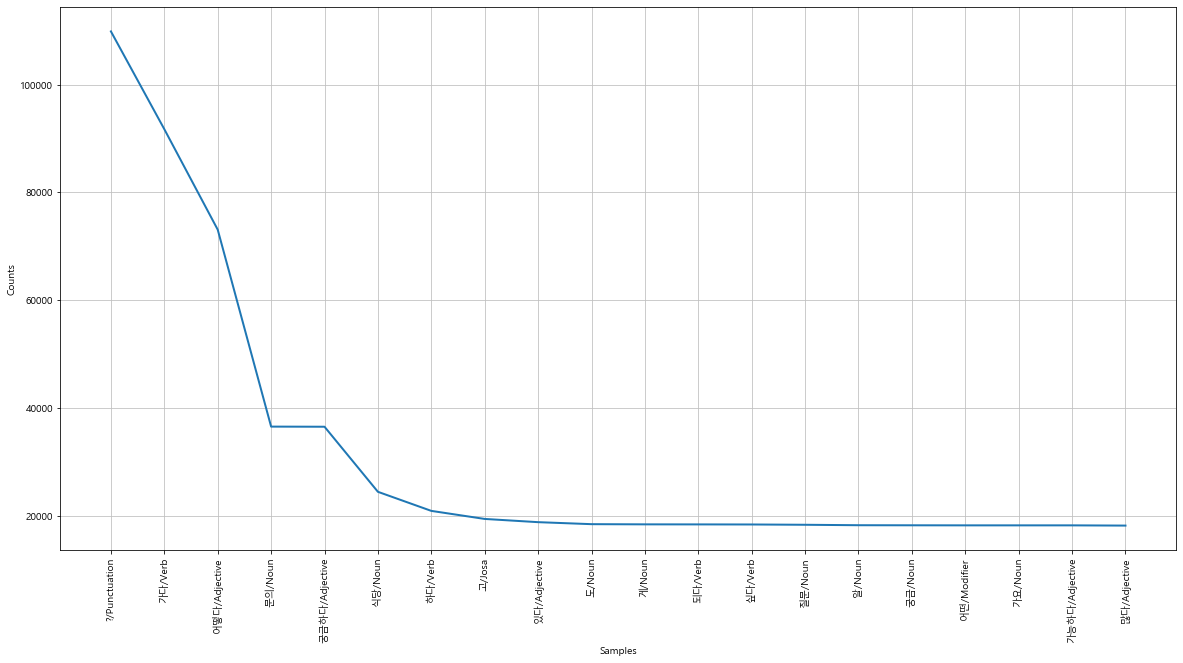

In [18]:
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
import platform
if platform.system() == 'Windows':
    font_name=font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
    rc('font', family=font_name)
else:
    rc('font', family='AppleGothic')

plt.figure(figsize=(20,10))
train_text.plot(20)
plt.show()

#### 텍스트 데이터 벡터화
자주 사용되는 단어 5000개를 사용하여 데이터를 벡터화
`CountVectorization`을 사용하여 문서 집합에서 단어 토큰을 생성하고
각 단어의 수를 세어 BOW(Bag og Words)인코딩한 벡터를 만든다.

In [19]:
my_bag_of_words = [f[0] for f in train_text.vocab().most_common(5000)]

def term_frequency(doc):
    return [doc.count(word) for word in my_bag_of_words]

In [20]:
x_train = [term_frequency(d) for d in train_docs]
x_test = [term_frequency(d) for d in test_docs]

데이터를 float로 형 변환

In [21]:
x_train = np.asarray(x_train).astype('float32')
x_test = np.asarray(x_test).astype('float32')

y_train = y_train.astype('float32')
y_test = y_test.astype('float32')

In [1]:
import numpy as np
import pandas as pd
import pickle
import re
import time
from konlpy.tag import Mecab

### 1. 데이터 탐색

In [2]:
with open("./questions/questions_pickle/X1_train_tfidf.pickle", "rb") as f:
    X_train = pickle.load(f)
with open("./questions/questions_pickle/X1_test_tfidf.pickle", "rb") as f:
    X_test = pickle.load(f)
with open("./questions/questions_pickle/tfidf_vocab_1.pickle", "rb") as f:
    tfidf_vocab = pickle.load(f)
with open("./questions/questions_pickle/tfidf_reversed_vocab_1.pickle", "rb") as f:
    tfidf_reversed_vocab = pickle.load(f)
with open("./questions/questions_pickle/y1_train.pickle", "rb") as f:
    y_train = pickle.load(f)
with open("./questions/questions_pickle/y1_test.pickle", "rb") as f:
    y_test = pickle.load(f)
with open("./questions/questions_pickle/lb_1.pickle", "rb") as f:
    lb = pickle.load(f)
with open("./questions/questions_pickle/tfidf_vectorizer_1.pickle", "rb") as f:
    tfidf_vectorizer = pickle.load(f)

In [3]:
X_train.shape, X_test.shape

((2707430, 117126), (300826, 117126))

In [4]:
y_train.shape, y_test.shape

((2707430, 3), (300826, 3))

In [5]:
lb.classes_

array(['questionLOC', 'questionREV', 'recommendation'], dtype='<U14')

In [6]:
tfidf_vectorizer

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=0.9, max_features=None,
                min_df=5, ngram_range=(1, 2), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(\\S+)', tokenizer=None,
                use_idf=True, vocabulary=None)

In [7]:
X_train

<2707430x117126 sparse matrix of type '<class 'numpy.float64'>'
	with 27139355 stored elements in Compressed Sparse Row format>

In [8]:
y_train

array([[0, 0, 1],
       [0, 1, 0],
       [0, 1, 0],
       ...,
       [0, 1, 0],
       [0, 1, 0],
       [1, 0, 0]])

In [7]:
y_train = y_train.astype(np.float32)
y_test = y_test.astype(np.float32)

In [8]:
%%time
x_train = X_train.toarray()

CPU times: user 15.7 s, sys: 25.9 s, total: 41.6 s
Wall time: 44.1 s


In [9]:
%%time
x_test = X_test.toarray()

CPU times: user 1.73 s, sys: 3 s, total: 4.73 s
Wall time: 5.06 s


In [10]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Embedding, LSTM, Dropout
from keras.layers import Conv1D, MaxPooling1D

Using TensorFlow backend.


In [18]:
Embedding?

In [11]:
model = Sequential()
model.add(Embedding(117126, 100))
model.add(Dropout(0.5))
model.add(Conv1D(64, 5, padding='valid', activation='relu', strides=1))
model.add(MaxPooling1D(pool_size=4))
model.add(LSTM(55))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [12]:
model.compile(loss='binary_crossentropy'
             , optimizer='adam'
             , metrics=['accuracy'])

In [13]:
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5) #조기종료 콜백함수 정의
hist = model.fit(x_train, y_train
                   , batch_size=20
                   , epochs=5
                   , validation_data=(x_test, y_test)
                   , callbacks=[early_stopping])

ValueError: Error when checking target: expected dense_2 to have shape (1,) but got array with shape (3,)

In [ ]:
#모델 학습 과정 표시
%matplotlib inline

fig, loss_ax = plt.subplot()

acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')

acc_ax.plot(hist.history['acc'], 'b', label='train acc')
acc_ax.plot(hist.history['val_acc'], 'g', label='val acc')

loss_ax.set_xlavel('epoch')
loss_ax.set_ylavel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

트레인 264750개 질문데이터에서 단어 1295542개 추출 후 최빈도 단어 5000개로 학습시킨 결과
정확도 0.9638의 결과가 나왔다.

### 문자열 형태의 새로운 데이터를 받아와서 결과를 예측하는 함수
데이터의 형태를 맞추기 위해 `np.expand_dims` 메서드를 이용해 array의 축을 확당했다.
최종 확률이 0.5보다 크면 문의, 그렇지 않으면 추천으로 예측

In [ ]:
def predict_review(review):
    token = tokenize(review)
    tf = term_frequency(token)
    data = np.expand_dims(np.asarray(tf).astype('float32'), axis=0)
    score = float(model.predict(data))
    if(score > 0.5):
        print("[{}]는 {:.2f}% 확률로 문의에 관한 질문입니다.\n".format(review, score*100))
    else:
        print("[{}]는 {:.2f}% 확률로 추천에 관한 질문입니다.\n".format(review, (1-score)*100))

In [ ]:
predict_review("주차 가능한가요?")
predict_review("매운 음식 추천해줘")
predict_review("아이 데리고 가기 좋은 가게 추천")
predict_review("데이트 하기 좋은 가게 추천해주세요")
predict_review("가게 깨끛한가요?")